In [1]:
import ee
import numpy as np
from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import predefined_cloud_algorithms

ee.Initialize()

region_of_interest = ee.Geometry.Polygon([[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]])
 
image_predict_clouds = ee.Image('LANDSAT/LC8_L1T_TOA_FMASK/LC81990332015174LGN00')
 
bands_model = ["B2","B3","B4"]
 
max_lags = 3
image_with_lags = multitemporal_cloud_masking.SelectImagesTraining(image_predict_clouds,region_of_interest,
                                                                   num_images=max_lags)
                                                                   

clouds_original = predefined_cloud_algorithms.QACloudMask(image_predict_clouds,strict=False)

# Add growing to the mask
clouds = clouds_original.reduceNeighborhood(ee.Reducer.max(),
                                            ee.Kernel.circle(radius=3))

modelo = multitemporal_cloud_masking.ModelCloudMasking(image_with_lags,bands_model,
                                                       clouds,max_lags,
                                                       region_of_interest,
                                                       seed=30)

lmbda = .0005
gamma = .5

In [2]:
modelo.TrainRBFKernelLocal(sampling_factor=.0001,lmbda=lmbda,gamma=gamma)

('Size of downloaded ds: ', (65, 10))


In [3]:
alpha_local = np.asanyarray(modelo.alpha.getInfo())
# print(alpha_local)

In [4]:
modelo.alpha = None
modelo.TrainRBFKernelServer(sampling_factor=.0001,lmbda=lmbda,gamma=gamma)
alpha_server = np.asanyarray(modelo.alpha.getInfo())
# print(alpha_server)

In [5]:
assert  np.sum(np.abs(alpha_server-alpha_local))< 1e-4, "alpha server and alpha local are not equal"

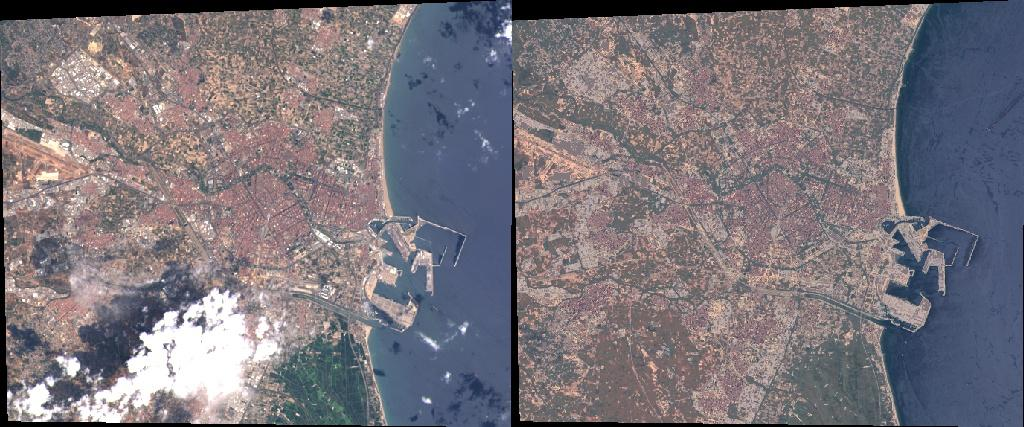

In [6]:
from ee_ipl_uv import download
from IPython.display import Image
img_predicha = modelo.PredictRBFKernel()

image_file_forecast = download.MaybeDownloadThumb(img_predicha.clip(region_of_interest),
                                                  params={"max":.3,"bands":"B4_forecast,B3_forecast,B2_forecast"})
image_file_original = download.MaybeDownloadThumb(image_predict_clouds.clip(region_of_interest),
                                                   params={"max":.3,"bands":"B4,B3,B2"})

mosaico = download.MosaicImageList([image_file_original,image_file_forecast],[1,2])
Image(mosaico)

## Cross Validation

In [7]:
from ee_ipl_uv import converters
sampling_factor = .0001
modelo._BuildDataSet(sampling_factor=sampling_factor, normalize=True)
bme = list(modelo.bands_modeling_estimation)
bme.append("weight")
ds_download_pd = converters.eeFeatureCollectionToPandas(modelo.datos, bme,
                                                        with_task=False)

ds_download_pd.head()

,B2,B3,B4,B2_lag_1,B3_lag_1,B4_lag_1,B2_lag_2,B3_lag_2,B4_lag_2,weight
0,0.006278,0.005902,0.037250,-0.100990,0.181816,0.608677,0.517441,0.430241,0.772842,0.018519
1,0.036784,0.042759,0.039890,0.900873,0.806106,0.447103,1.158611,0.735168,0.362385,0.018519
2,0.022644,0.033507,0.045782,1.007252,0.794642,0.681607,1.424237,1.057346,0.894853,0.018519
3,-0.028309,-0.031696,-0.052961,-1.459301,-0.925380,-0.855269,-0.875644,-0.686473,-0.756987,0.018519
4,-0.032695,-0.049044,-0.064329,0.483298,0.744011,0.845849,0.891318,0.912747,1.038137,0.018519


In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
pesos = np.asanyarray(ds_download_pd.weight)
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": np.logspace(-3, 2, 6),
                              "gamma": np.logspace(-3, 2, 6)},
                 fit_params={"sample_weight":pesos})


print("Size of downloaded ds: ", ds_download_pd.shape)
kr.fit(ds_download_pd[modelo.bands_modeling_estimation_input],
       ds_download_pd[modelo.bands_modeling_estimation_output])

kr.best_params_


('Size of downloaded ds: ', (65, 10))


{'alpha': 0.001, 'gamma': 0.01}

In [9]:
print(kr.best_params_)
score1 = kr.score(ds_download_pd[modelo.bands_modeling_estimation_input],
                  ds_download_pd[modelo.bands_modeling_estimation_output])
print(score1)


{'alpha': 0.001, 'gamma': 0.01}
0.891014288229


In [10]:
kernel2 = KernelRidge(kernel='rbf', gamma=kr.best_params_["gamma"],alpha=kr.best_params_["alpha"])
kernel2.fit(ds_download_pd[modelo.bands_modeling_estimation_input],
            ds_download_pd[modelo.bands_modeling_estimation_output],
            sample_weight= pesos)
score_2 = kernel2.score(ds_download_pd[modelo.bands_modeling_estimation_input],
                        ds_download_pd[modelo.bands_modeling_estimation_output])

print(score_2)

assert score1 == score_2, "data is not trained in the full dataset"

0.891014288229


## Compare with our implementation

In [11]:
modelo.alpha = None
modelo.kernel_rbf = None
modelo.TrainRBFKernelLocal(sampling_factor=sampling_factor,with_cross_validation=True)
alpha_local_cv = np.asanyarray(modelo.alpha.getInfo())

np.testing.assert_allclose(alpha_local_cv, kr.best_estimator_.dual_coef_)

('Size of downloaded ds: ', (65, 10))
('CV params:', {'alpha': 0.001, 'gamma': 0.01})


In [12]:
modelo.alpha = None
modelo.TrainRBFKernelServer(sampling_factor=sampling_factor,lmbda=kr.best_params_["alpha"],
                            gamma=kr.best_params_["gamma"])
alpha_server_cv = np.asanyarray(modelo.alpha.getInfo())

assert  np.sum(np.abs(alpha_server_cv-alpha_local_cv))< 1e-4, "alpha server and alpha local are not equal"

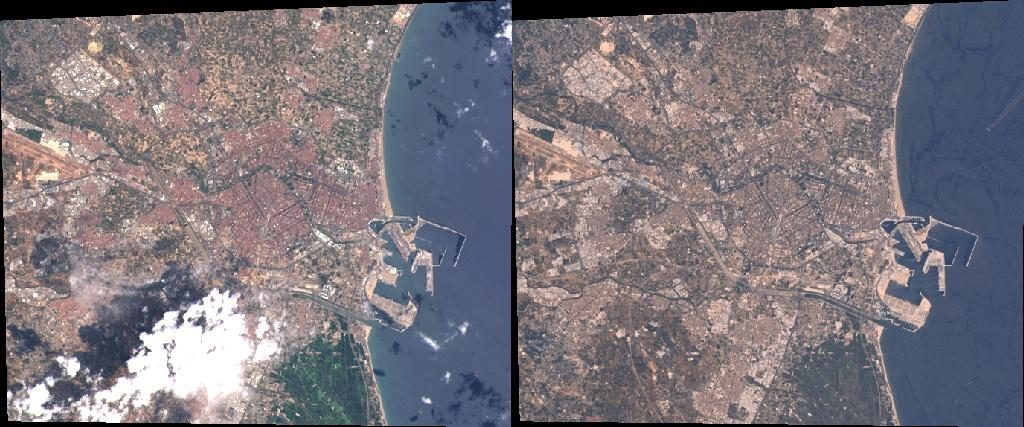

In [13]:
from ee_ipl_uv import download
from IPython.display import Image
img_predicha = modelo.PredictRBFKernel()

image_file_forecast_cv = download.MaybeDownloadThumb(img_predicha.clip(region_of_interest),
                                                     params={"max":.3,"bands":"B4_forecast,B3_forecast,B2_forecast"})


mosaico = download.MosaicImageList([image_file_original,image_file_forecast_cv],[1,2])
Image(mosaico)